In [1]:
# %load "C:\Users\Ziyad\Desktop\Kernel_methods\kernel.py"
from math import exp, sqrt
import numpy.linalg as npl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def Gk_image(x,t,sigma=1):
    """
    For real vectors x and t returns their image by the
    gaussian kernel
    
    Parameters
    ----------
    x : array like - 1D array
    t : array like - 1D array
    
    Returns
    -------
    y : float

    """
    y=exp(-npl.norm(x-t)**2/sigma**2)
    
    return y
#--------------------------------------------------------

def Gk_distance(x,y,sigma=1):
    """
    for real vectors x and y computes the distance
    between their images in the gaussian kernel Hilbert 
    space 

    Parameters
    ----------
    x : array like - 1D array
    y : array like - 1D array

    Returns
    -------
    d : float

    """
    d=sqrt(2*(1-Gk_image(x,y,sigma)))
    return d

#--------------------------------------------------------

def Gk_gram_matrix(x,sigma=1):
    """
    for a dataset x return the matrix A that has for 
    entries A(i,j) = the image of the i line and the j
    line by the gaussian kernel
    
    Parameters
    ----------
    x : array like - 2D array

    Returns
    -------
    y : array like - 2D array

    """
    (n,p)=x.shape
    
    y=np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            l=x[i,:]
            m=x[j,:]
            y[i][j]=Gk_image(l,m,sigma)
    y=y + y.T - np.diag(y.diagonal())
    return y

#--------------------------------------------------------

class Gk_PCA:
    
    
    def __init__(self,dataset,sigma=1):
        self.sigma=sigma
        self.dataset=dataset
        self.K=np.zeros(dataset.shape)
        self.directions=[]
        self.explained_variance=[]
        
    def compute_gram_matrix(self):
        self.K=Gk_gram_matrix(self.dataset,self.sigma)
        
    def compute_directions(self):
        
        ## Centered Gram matrix
        n=self.K.shape[0]
        m=np.ones((n,n))/n
        i=np.eye(n)
        self.K_c=(i-m) @ self.K @ (i-m)
        
        ## Eigenvalues
        w,v=npl.eigh(self.K_c)
        order=np.argsort(-w)
        w=w[order]
        v=v[:,order]
        i=0
        while w[i]>=0:
            if i<=n:
                i=i+1
            else:
                break
        w=w[0:i]
        v=v[:,0:i]
        
        #Directions
        D=np.zeros((n,i))
        for j in range (i):
            D[:,j]=v[:,j]/sqrt(w[j])
        
        self.directions=D
        
        #Explained_variance
        for j in range (i):
            self.explained_variance.append(1/n*D[:,j].T
                @ self.K_c @ self.K_c @ D[:,j])
        
        
        
    def reduce(self):
        return self.K_c @ self.directions
    
    def scree_plot(self):
        x = np.arange(len(self.explained_variance))+1
        plt.plot(x, self.explained_variance, 'o-', linewidth=2, color='blue')
        plt.title('Scree Plot')
        plt.xlabel('Principal Component')
        plt.ylabel('Variance Explained')
        plt.show()
        
    def plot(self):
        x=self.reduce()
        plt.scatter(x[:,0],x[:,1])
        plt.xlabel('First component')
        plt.ylabel('Second component')
        plt.show()
                
            
#--------------------------------------------------------

class Gk_SpectralClustering :
    
    def __init__(self,nb_clusters,dataset,sigma=1):
        self.k=nb_clusters
        self.dataset=dataset
        self.sigma=sigma
        
    def compute_gram_matrix(self):
        self.K=Gk_gram_matrix(self.dataset,self.sigma)
        
    def compute_clusters(self):
        ## Centered Gram matrix
        n=self.K.shape[0]
        m=np.ones((n,n))/n
        i=np.eye(n)
        self.K_c=(i-m) @ self.K @ (i-m)
        
        ## Eigenvalues
        w,v=npl.eigh(self.K_c)
        order=np.argsort(-w)
        w=w[order]
        v=v[:,order]
        self.Z=v[:,0:self.k]
        
        ## Normalize Z
        A=self.Z
        norm=npl.norm(A,axis=1)
        for i in range(n):
            A[i,:]=A[i,:]/norm[i]
        
        ## Regular KMeans to A
        km=KMeans(n_clusters=self.k)
        return(km.fit_predict(A))

# Single nucleus RNA-seq of cell diversity in the adult mouse hippocampus (sNuc-Seq)

## Importation des données 

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv(r"C:\Users\Ziyad\Desktop\Kernel_methods\Dataset\Count_Matrix.txt",index_col=0)

In [4]:
df.head()

,Itm2a,Sergef,Chil5,Fam109a,Dhx9,Ssu72,Olfr1018,Fam71e2,Eif2b2,1700061E18Rik,...,Itgb1bp2,Olfr372,Ctsw,Gosr1,Ryk,Rhd,Pxmp4,4930455C13Rik,Reg4,Prss39
A1-P1-DG_S100_L001_R1_001,0.0,0.000000,0.0,0.000000,0.000000,154.934121,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,24.878401,0.000000,0.0,0.0
A1-P1-DG_S101_L001_R1_001,0.0,1202.310018,0.0,0.000000,22.109337,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,1053.633557,0.000000,0.0,0.000000,0.000000,0.0,0.0
A1-P1-DG_S102_L001_R1_001,0.0,0.000000,0.0,67.020598,99.384881,625.780706,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
A1-P1-DG_S103_L001_R1_001,0.0,1828.040670,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
A1-P1-DG_S104_L001_R1_001,0.0,900.544878,0.0,0.000000,61.436247,0.000000,0.0,0.0,0.0,0.0,...,1119.905964,0.0,0.0,0.000000,597.049485,0.0,51.676338,149.157083,0.0,0.0


In [5]:
x=df.to_numpy()

In [59]:
print(x.shape)

(1402, 25392)


In [58]:
print(x.shape[0])

1402


## Choix du paramètre du noyau gaussien

On choisira la médiane des distances entre les observations.

In [12]:
v=[]
for i in range(1402):
    for j in range(i+1,1402):
            v.append(np.linalg.norm(x[i]-x[j]))

In [57]:
sig=np.median(v)
print(sig)

148258.84720953368


## Kernel PCA

In [18]:
my_pca=Gk_PCA(dataset=x,sigma=sig)

In [19]:
import time
t1=time.time()
my_pca.compute_gram_matrix()
t2=time.time()

In [56]:
print(t2-t1)

338.54512429237366


Le calcul de la matrice de Gram prend entre 5 et 6 minutes.

Affichons la matrice :

In [55]:
print(my_pca.K)

[[1.         0.58628962 0.21141582 ... 0.61426899 0.588176   0.60956258]
 [0.58628962 1.         0.20923996 ... 0.53586678 0.49172997 0.50293011]
 [0.21141582 0.20923996 1.         ... 0.25257234 0.26445948 0.27680821]
 ...
 [0.61426899 0.53586678 0.25257234 ... 1.         0.75447369 0.75255885]
 [0.588176   0.49172997 0.26445948 ... 0.75447369 1.         0.74382013]
 [0.60956258 0.50293011 0.27680821 ... 0.75255885 0.74382013 1.        ]]


In [60]:
print(my_pca.K.shape)

(1402, 1402)


In [23]:
my_pca.compute_directions()

In [35]:
r=my_pca.reduce()

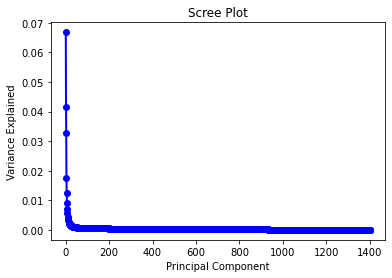

In [25]:
my_pca.scree_plot()

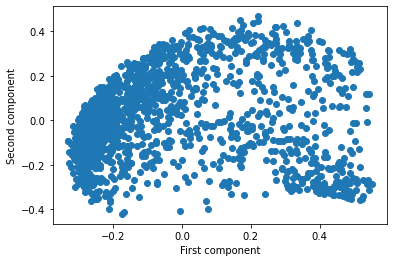

In [26]:
my_pca.plot()

## Visualisation des clusters dans le plan factoriel

In [27]:
clusters=pd.read_csv(r"C:\Users\Ziyad\Desktop\Kernel_methods\Dataset\CLUSTER_AND_SUBCLUSTER_INDEX.txt",delim_whitespace=True)

In [28]:
clusters=clusters.drop(labels=0)

In [63]:
clusters.head()

,NAME,CLUSTER,SUB-CLUSTER
1,A1-P1-DG_S100_L001_R1_001,DG,DG_Penk
2,A1-P1-DG_S101_L001_R1_001,DG,DG_Cck
3,A1-P1-DG_S102_L001_R1_001,GABAergic,Gad2_Sst
4,A1-P1-DG_S103_L001_R1_001,DG,DG_Cck
5,A1-P1-DG_S104_L001_R1_001,DG,DG_Penk


In [61]:
cluster_list=list(set(clusters['CLUSTER']))
print(cluster_list)

['Ependymal', 'CA2', 'GABAergic', 'Non', 'DG', 'Glia', 'CA1', 'CA3']


In [31]:
labels=clusters['CLUSTER']

In [40]:
l=np.array(labels)
cl=[]
for i in l:
    cl.append(cluster_list.index(i))

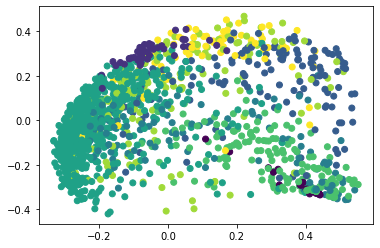

In [42]:
plt.scatter(r[:,0],r[:,1],c=cl);

## Spectral clustering

In [45]:
sc=Gk_SpectralClustering(dataset=x,nb_clusters=6,sigma=sig)

In [46]:
sc.compute_gram_matrix()

In [47]:
c=sc.compute_clusters()

In [53]:
from sklearn.metrics import homogeneity_score, completeness_score

print(homogeneity_score(l,c))

0.43408329744812746


In [54]:
print(completeness_score(l,c))

0.40090339718998025


Les performances de l'algorithme ne sont impressionnantes.

# Toy dataset

Appliquons nos fonctions pour des données issues du mélange de deux gaussiennes.

In [64]:
from sklearn.datasets import make_blobs

dataset=make_blobs(n_samples=1000,n_features=20000,centers=2,cluster_std=2)